# Goal

Accuracy as a function of isotope incorporation & community similarity among replicate microcosms

### Variable parameters:

* shared % of taxa
  * 80, 85, 90, 95, 100
* permuted % of rank abundances
  * 20, 15, 10, 5, 0
* atom % isotope incorporation
  * 100
* % taxa that incorporate
  * 10
* n-reps (stocastic: taxon abundances & which incorporate)
  * 10 

# Setting paths

In [42]:
import os

# paths
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/'
buildDir = os.path.join(workDir, 'microBetaDiv')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde.pkl'
genome_index = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

## Init

In [43]:
import glob
import itertools
import nestly

In [44]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [45]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [46]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)
%cd $buildDir

/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv


### BD min/max

In [47]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [48]:
# making an experimental design file for qSIP
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(buildDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile       

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


## Nestly params

In [49]:
# building tree structure
nest = nestly.Nest()

# varying params: test
#nest.add('shared_perc', [90, 95])
#nest.add('perm_perc', [5, 10])
#nest.add('rep', range(1,4))

# varying params
nest.add('shared_perc', [80, 85, 90, 95, 100])
nest.add('perm_perc', [0, 5, 10, 15, 20])
nest.add('rep', range(1,11))

## set params
nest.add('percIncorp', [100], create_dir=False)
nest.add('percTaxa', [10], create_dir=False)

nest.add('abs', ['1e9'], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('Monte_rep', [100000], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)
nest.add('DBL_scaling', [0.5], create_dir=False)
nest.add('bandwidth', [0.8], create_dir=False)
nest.add('heavy_BD_min', [1.71], create_dir=False)
nest.add('heavy_BD_max', [1.75], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('genome_index', [genome_index], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('exp_design', [expDesignFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

## Experimental design

In [9]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_expDesign.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_expDesign.sh'

In [10]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- Experimental design --#'

echo '# Making an isotope incorporation config file'
echo '## 3 replicate gradients for control & treatment'
SIPSim incorpConfigExample \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > incorp.config

echo '# Selecting incorporator taxa'
echo '## This is to make the gradient replicates consistent (qSIP finds mean among replicates)'
SIPSim KDE_selectTaxa \
    -p {percTaxa} \
    {fragFile} \
    > incorporators.txt

echo '# Creating a community file (3 replicate control, 3 replicate treatment)'
SIPSim communities \
    --richness 950 \
    --config incorp.config \
    --shared_perc {shared_perc} \
    --perm_perc {perm_perc} \
    {genome_index} \
    > comm.txt    

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    --BD_min {min_BD} \
    --BD_max {max_BD} \
    comm.txt \
    > fracs.txt        

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_expDesign.sh


In [11]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file exp_design.log -j 10

2016-04-20 11:39:18,435 * INFO * Template: ./SIPSimRun_expDesign.sh
2016-04-20 11:39:18,437 * INFO * [181437] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7
2016-04-20 11:39:18,439 * INFO * [181438] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9
2016-04-20 11:39:18,441 * INFO * [181439] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/8
2016-04-20 11:39:18,442 * INFO * [181442] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/3
2016-04-20 11:39:18,444 * INFO * [181444] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/10
2016-04-20 11:39:18,446 * INFO * [181446] Started ./SIPSimRun_expDesign.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/2
2016-04-20 11:39:18,447 * INFO * [181448] Started ./SIPSimRun

In [12]:
%pushnote exp_design complete: $buildDir

## SIPSim pipeline

In [13]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-pipeline.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_SIPSim-pipeline.sh'

In [ ]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- SIPSim pipeline --#'    
    
echo '# Adding diffusion'    
SIPSim diffusion \
    -n {Monte_rep} \
    --bw {bandwidth} \
    --np {np} \
    {fragFile} \
    > ampFrags_KDE_dif.pkl    

echo '# Adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    -n {Monte_rep} \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --np {np} \
    ampFrags_KDE_dif.pkl \
    > ampFrags_KDE_dif_DBL.pkl 

echo '# Adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    -n {Monte_rep} \
    --comm comm.txt \
    --taxa incorporators.txt \
    --np {np} \
    ampFrags_KDE_dif_DBL.pkl \
    incorp.config \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# Simulating an OTU table'
SIPSim OTU_table \
    --abs {abs} \
    --np {np} \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    > OTU_abs{abs}.txt
    
echo '# Simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# Subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# Making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# Making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
       

#-- removing large intermediate files --#
rm -f ampFrags_KDE_dif.pkl
rm -f ampFrags_KDE_dif_DBL.pkl
rm -f ampFrags_KDE_dif_DBL_inc.pkl    

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_SIPSim-pipeline.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_pipeline.log -j 2

2016-04-20 11:41:36,793 * INFO * Template: ./SIPSimRun_SIPSim-pipeline.sh
2016-04-20 11:41:36,795 * INFO * [210119] Started ./SIPSimRun_SIPSim-pipeline.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7
2016-04-20 11:41:36,797 * INFO * [210120] Started ./SIPSimRun_SIPSim-pipeline.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9


In [ ]:
%pushnote SIPSim pipeline complete: $buildDir

## Summary of simulated data

In [ ]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-summary.sh'
bashFileTmp

In [ ]:
%%writefile $bashFileTmp
#!/bin/bash
   
# plotting 'raw' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}

# plotting 'sequenced' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}_PCR_sub.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}_PCR_sub

In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_summary.log -j 10

## HR-SIP: DESeq2

In [ ]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_HRSIP.sh'
bashFileTmp

In [ ]:
%%writefile $bashFileTmp
#!/bin/bash

# phyloseq
## making phyloseq object from OTU table
SIPSimR phyloseq_make \
    OTU_abs{abs}_PCR_sub_w.txt \
    -s OTU_abs{abs}_PCR_sub_meta.txt \
    > OTU_abs{abs}_PCR_sub.physeq

## filtering phyloseq object to just 'heavy' fractions
SIPSimR phyloseq_edit \
    OTU_abs{abs}_PCR_sub.physeq \
    --BD_min {heavy_BD_min} \
    --BD_max {heavy_BD_max} \
    > OTU_abs{abs}_PCR_sub_filt.physeq

## making ordination
SIPSimR phyloseq_ordination \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    OTU_abs{abs}_PCR_sub_filt_bray-NMDS.pdf

# DESeq2
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    > OTU_abs{abs}_PCR_sub_filt_DESeq2

In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file HR-SIP.log -j 10

In [ ]:
%pushnote HR-SIP complete: $buildDir

## MW-HR-SIP

* BD windows: 1.70-1.73,1.72-1.75,1.74-1.77

In [133]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_MWHRSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_MWHRSIP.sh'

In [134]:
%%writefile $bashFileTmp
#!/bin/bash

## HR SIP pipeline
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    --occur_all 0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5 \
    -w 1.70-1.73,1.72-1.75,1.74-1.77 \
    --all OTU_abs1e9_PCR_sub_MW-all.txt \
    OTU_abs{abs}_PCR_sub.physeq \
    > OTU_abs{abs}_PCR_sub_filt_MW_DESeq2

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_MWHRSIP.sh


In [135]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file MW-HR-SIP.log -j 14

2016-05-15 08:38:35,511 * INFO * Template: ./SIPSimRun_MWHRSIP.sh
2016-05-15 08:38:35,513 * INFO * [197078] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7
2016-05-15 08:38:35,515 * INFO * [197079] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9
2016-05-15 08:38:35,516 * INFO * [197081] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/8
2016-05-15 08:38:35,517 * INFO * [197083] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/3
2016-05-15 08:38:35,519 * INFO * [197085] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/10
2016-05-15 08:38:35,522 * INFO * [197087] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/2
2016-05-15 08:38:35,524 * INFO * [197090] Started ./SIPSimRun_MWHRSIP.sh in

In [136]:
%pushnote MW-HR-SIP complete: $buildDir

## MW-HR-SIP: debug

* BD windows: 1.70-1.73,1.72-1.75,1.74-1.77
* l2fc cutoff of 0.5 (instead of 0.25)

In [206]:
# bashFileTmp = os.path.splitext(bashFile)[0] + '_MWHRSIP2.sh'
# bashFileTmp

In [207]:
%%writefile $bashFileTmp
#!/bin/bash

# ## HR SIP pipeline
# SIPSimR phyloseq_DESeq2 \
#     --log2 0.5 \
#     --hypo greater \
#     --cont 1,3,5 \
#     --treat 2,4,6 \
#     --occur_all 0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5 \
#     -w 1.70-1.73,1.72-1.75,1.74-1.77 \
#     --all OTU_abs1e9_PCR_sub_MW0.5-all.txt \
#     OTU_abs{abs}_PCR_sub.physeq \
#     > OTU_abs{abs}_PCR_sub_filt_MW0.5_DESeq2

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_cMtx.sh


In [208]:
# !chmod 777 $bashFileTmp
# !cd $workDir; \
#     nestrun --template-file $bashFileTmp -d $buildDir --log-file MW0.5-HR-SIP.log -j 14

In [181]:
#%pushnote MW0.5-HR-SIP complete: $buildDir

## qSIP

In [ ]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_qSIP.sh'
bashFileTmp

In [ ]:
%%writefile $bashFileTmp
#!/bin/bash


# qSIP
SIPSim qSIP \
    OTU_abs{abs}.txt \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_qSIP.txt
        

# qSIP: atom excess
SIPSim qSIP_atomExcess \
    --np {np} \
    OTU_abs{abs}_PCR_sub_qSIP.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_qSIP_atom.txt  

In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file qSIP.log -j 2

In [ ]:
%pushnote qSIP complete: $buildDir

## deltaBD

In [70]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_dBD.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_dBD.sh'

In [51]:
%%writefile $bashFileTmp
#!/bin/bash

#deltaBD 
SIPSim deltaBD \
    OTU_abs{abs}_PCR_sub.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_dBD.txt  

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_dBD.sh


In [52]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file deltaBD.log -j 4

2016-04-26 12:46:49,856 * INFO * Template: ./SIPSimRun_dBD.sh
2016-04-26 12:46:49,858 * INFO * [43597] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7
2016-04-26 12:46:49,859 * INFO * [43598] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9
2016-04-26 12:46:49,861 * INFO * [43599] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/8
2016-04-26 12:46:49,862 * INFO * [43602] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/3
2016-04-26 12:46:53,841 * INFO * [43598] /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9 Finished with 0
2016-04-26 12:46:53,843 * INFO * [43713] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/10
2016-04-26 12:46:53,892 * INFO * [43597] /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7 Finished with 0

In [53]:
%pushnote deltaBD complete: $buildDir

## Making confusion matrices

In [182]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_cMtx.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_cMtx.sh'

In [183]:
%%writefile $bashFileTmp
#!/bin/bash

# HR-SIP
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_DESeq2

# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_multi-cMtx \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_MW_DESeq2  
    
# HR-SIP multiple 'heavy' BD windows: l2fc_cut=0.5
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_l2fcCut0.5-multi-cMtx \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_MW0.5_DESeq2  
        
    
# qSIP    
SIPSimR qSIP_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_qSIP_atom.txt

# heavy-SIP    
SIPSimR heavy_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub.txt

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/SIPSimRun_cMtx.sh


In [184]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file cMtx.log -j 14

2016-05-16 07:50:24,913 * INFO * Template: ./SIPSimRun_cMtx.sh
2016-05-16 07:50:24,916 * INFO * [16316] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/7
2016-05-16 07:50:24,919 * INFO * [16317] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/9
2016-05-16 07:50:24,922 * INFO * [16319] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/8
2016-05-16 07:50:24,924 * INFO * [16321] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/3
2016-05-16 07:50:24,927 * INFO * [16323] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/10
2016-05-16 07:50:24,928 * INFO * [16325] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/80/20/2
2016-05-16 07:50:24,930 * INFO * [16327] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev

### Aggregating the confusion matrix data

In [185]:
def agg_cMtx(prefix):
    # all data
    #!nestagg delim \
    #    -d $buildDir \
    #    -k percIncorp,percTaxa,rep \
    #    -o $prefix-cMtx_data.txt \
    #    --tab \
    #    $prefix-cMtx_data.txt

    # overall
    x = prefix + '-cMtx_overall.txt'
    !nestagg delim \
        -d $buildDir \
        -k shared_perc,perm_perc,rep \
        -o $x \
        --tab \
        $x

    # by class
    x = prefix + '-cMtx_byClass.txt'
    !nestagg delim \
        -d $buildDir \
        -k shared_perc,perm_perc,rep \
        -o $x \
        --tab \
        $x
        
agg_cMtx('DESeq2')
agg_cMtx('DESeq2_multi')
agg_cMtx('DESeq2_l2fcCut0.5-multi')
agg_cMtx('qSIP') 
agg_cMtx('heavy') 

In [186]:
%pushnote microBetaDiv complete!

***
# --End of simulation--#
***

# Plotting results

In [209]:
F = os.path.join(buildDir, '*-cMtx_byClass.txt')
files = glob.glob(F)
files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/DESeq2-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/DESeq2_l2fcCut0.5-multi-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/qSIP-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/heavy-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/DESeq2_multi-cMtx_byClass.txt']

In [215]:
%%R -i files

df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)
df_byClass = filter(df_byClass, perm_perc <= 20)

df_byClass %>% head(n=3)

  library      variables    values shared_perc perm_perc rep
1       2    Sensitivity 0.5940594          80        20   7
2       2    Specificity 0.9168421          80        20   7
3       2 Pos Pred Value 0.4316547          80        20   7
                     file method
1 DESeq2-cMtx_byClass.txt DESeq2
2 DESeq2-cMtx_byClass.txt DESeq2
3 DESeq2-cMtx_byClass.txt DESeq2


In [216]:
%%R
# renaming method
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'qSIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

  library      variables    values shared_perc perm_perc rep
1       2    Sensitivity 0.5940594          80        20   7
2       2    Specificity 0.9168421          80        20   7
3       2 Pos Pred Value 0.4316547          80        20   7
                     file method
1 DESeq2-cMtx_byClass.txt HR-SIP
2 DESeq2-cMtx_byClass.txt HR-SIP
3 DESeq2-cMtx_byClass.txt HR-SIP


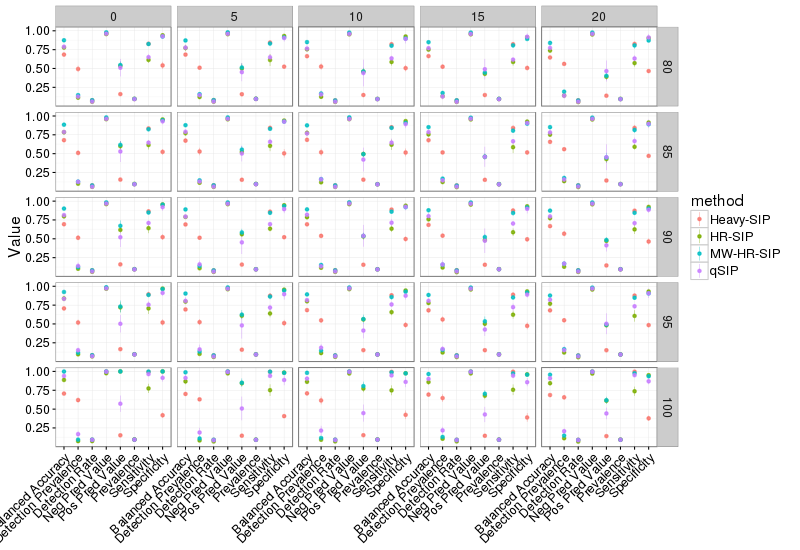

In [217]:
%%R -w 800 -h 550
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, shared_perc, perm_perc, variables) %>%
    summarize(mean_value = mean(values),
              sd_value = sd(values))

# plotting
ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(shared_perc ~ perm_perc) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

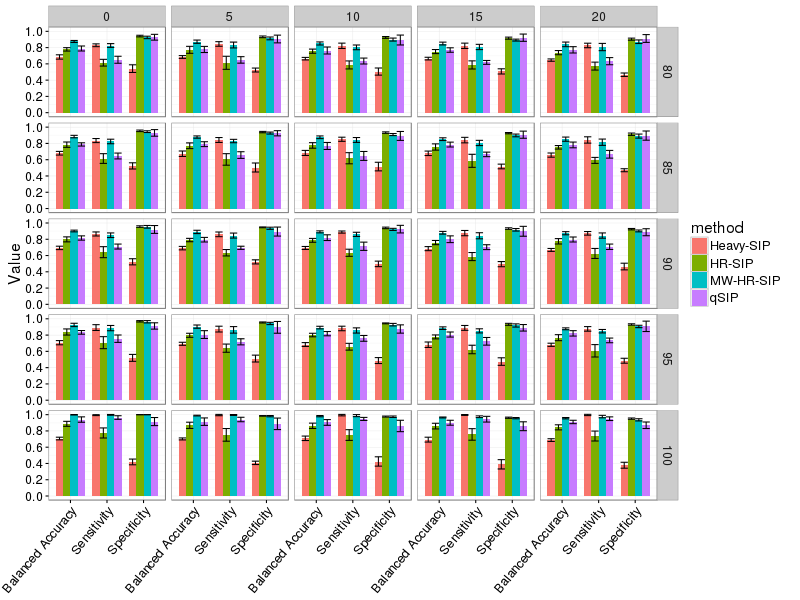

In [218]:
%%R -w 800 -h 600
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) 

# plotting
ggplot(df_byClass.s.f, aes(variables, mean_value, fill=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    #geom_pointrange(alpha=0.8, size=0.2) +
    geom_bar(stat='identity', position='dodge', width=0.8) +
    geom_errorbar(stat='identity', position='dodge', width=0.8) +
    scale_y_continuous(breaks=seq(0, 1, 0.2)) +
    labs(y='Value') +
    facet_grid(shared_perc ~ perm_perc) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=50, hjust=1)
    )

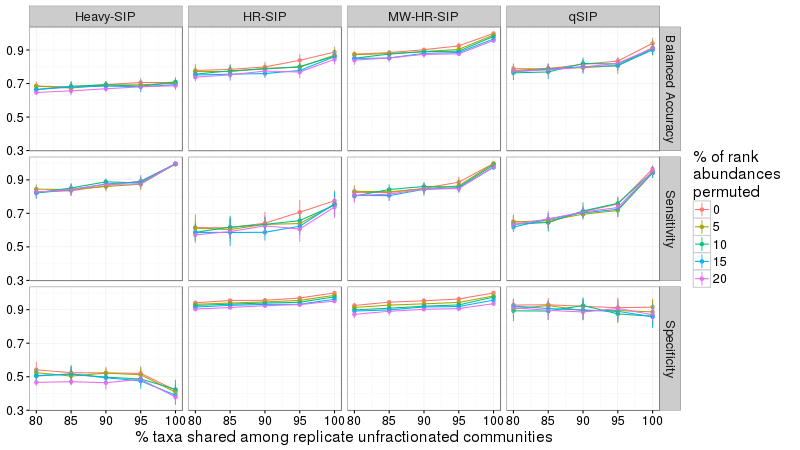

In [219]:
%%R -w 800 -h 450
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(perm_perc = perm_perc %>% as.character,
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric))

# plotting
p.pnt = ggplot(df_byClass.s.f, aes(shared_perc, mean_value, 
                           color=perm_perc, 
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared among unfractionated communities') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_blank()
    )
p.pnt

**Notes**

* The lowered specificity for (MW-)HR-SIP is mainly due to community structure differences between control and treatment gradients. 

In [220]:
%%R 
outFile = 'microBetaDiv_acc.pdf'
ggsave(outFile, p.pnt, width=10, height=5.63)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/microBetaDiv_acc.pdf 


### Plot number of false positives

* emphasize the issue of specificity

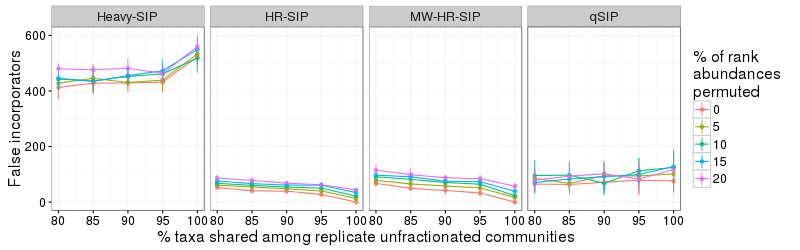

In [226]:
%%R -w 800 -h 250
# theoretical number of taxa
df.ntaxa = data.frame(
    'variables' = rep('Specificity', 3),
    'ntaxa' = c(500, 900, 2000)
)

df_byClass.j = inner_join(df_byClass, df.ntaxa, c('variables'='variables')) %>%
    mutate(nFP = (1-values) * ntaxa) %>%
    group_by(method, shared_perc, perm_perc, ntaxa) %>%
    summarize(mean_nFP = mean(nFP, na.rm=TRUE),
              sd_nFP = sd(nFP, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(perm_perc = perm_perc %>% as.character,
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric),
           ntaxa = ntaxa %>% as.character) %>%
    filter(ntaxa == 900)

# plotting
p.FP = ggplot(df_byClass.j, aes(shared_perc, mean_nFP, 
                           color=perm_perc, group=perm_perc,
                           ymin=mean_nFP-sd_nFP,
                           ymax=mean_nFP+sd_nFP)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% of rank\nabundances\npermuted') +
    labs(x='% taxa shared replicate unfractionated communities',
         y='False incorporators') +
    facet_grid( ~ method, scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.FP 

### Combined figure

In [223]:
%%R
g_legend = function(a.gplot){ 
  tmp = ggplot_gtable(ggplot_build(a.gplot)) 
  leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
  legend = tmp$grobs[[leg]] 
  return(legend)
  }
                     
p.leg = g_legend(p.pnt)

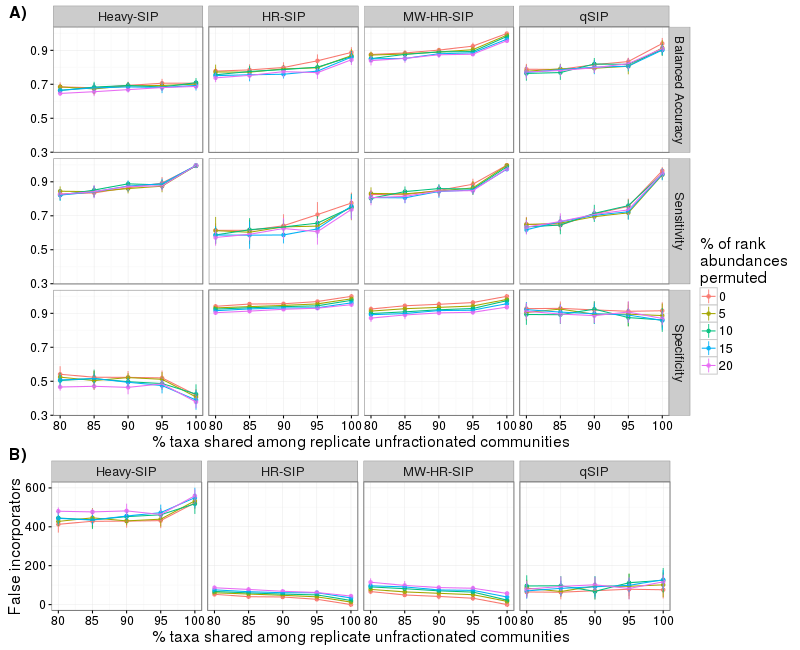

In [238]:
%%R -w 800 -h 650

p.pnt.e = p.pnt + theme(legend.position='none')
p.FP.e = p.FP + theme(legend.position='none')

# p.comb = cowplot::ggdraw() +
#     cowplot::draw_plot(p.pnt.e, 0.03, 0.3, 0.875, 0.7) +
#     cowplot::draw_plot(p.FP.e, 0, 0, 0.88, 0.3) +
#     cowplot::draw_plot(p.leg, 0.92, 0.38, 0.08, 0.3) +
#     cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.31))
# p.comb

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), color='white', fill='white') +
    cowplot::draw_plot(p.pnt.e, 0.03, 0.3, 0.84, 0.7) +
    cowplot::draw_plot(p.FP.e, 0, 0, 0.845, 0.3) +
    cowplot::draw_plot(p.leg, 0.89, 0.38, 0.08, 0.3) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.32))
p.comb

In [241]:
%%R
outFile = 'microBetaDiv_acc-FP.pdf'
ggsave(outFile, p.comb, width=10, height=8.65)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/microBetaDiv_acc-FP.pdf 


***

# atom excess estimates

## qSIP

In [261]:
atomX_files = glob.glob('*/*/*/*_atom.txt')
len(atomX_files)

400

In [262]:
%%R -i atomX_files

df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3)

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


In [264]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

400

In [265]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon shared_perc perm_perc   rep
                          (fctr)       (chr)     (chr) (chr)
1 Acaryochloris_marina_MBIC11017         100         0     1
2 Acaryochloris_marina_MBIC11017         100         0    10
3 Acaryochloris_marina_MBIC11017         100         0     2
Variables not shown: median_true_BD_shift (dbl)


In [266]:
%%R
as.Num = function(x) x %>% as.character %>% as.numeric

df.j = inner_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'shared_perc'='shared_perc',
                                       'perm_perc'='perm_perc',
                                       'rep'='rep')) %>%
    mutate(shared_perc = shared_perc %>% as.Num,
           perm_perc = perm_perc %>% as.Num) %>%
    filter(!is.na(BD_diff),
           perm_perc <= 20) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))
df.j %>% head(n=3)

                                 taxon  control treatment       BD_diff
1       Acaryochloris_marina_MBIC11017 1.708033  1.709418  0.0013851679
2 Acetobacter_pasteurianus_IFO_3283-03 1.712330  1.712616  0.0002866604
3       Acetobacterium_woodii_DSM_1030 1.704179  1.703843 -0.0003364652
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7421776   308.0591         317.6635     308.3089          0.025722669
2  0.7936284   308.0846         317.6634     308.1362          0.005324613
3  0.6960235   308.0362         317.6637     307.9754         -0.006246878
   atom_CI_low atom_CI_high shared_perc perm_perc rep
1 -0.007952873   0.05800202          80        20   7
2 -0.013487728   0.02572328          80        20   7
3 -0.025040726   0.01425911          80        20   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt              

In [267]:
%%R
# free memory
df_shift = df_atomX = NULL

# saving dataframe (if needed)
df.j.qSIP = df.j 

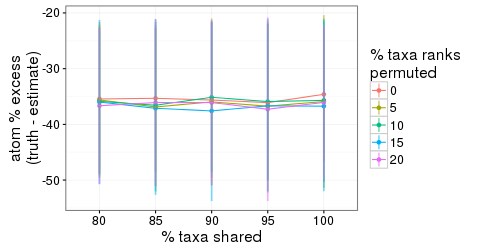

In [268]:
%%R -h 250 
# difference between true and estimated
df.j.dis.qSIP = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc, true_incorporator) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric)) %>%
    filter(true_incorporator == TRUE)
   
# plotting
ggplot(df.j.dis.qSIP, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_point() +
    geom_linerange(alpha=0.5, size=0.8) +
    geom_line() +
    scale_color_discrete('% taxa ranks\npermuted') +
    labs(x='% taxa shared', y='atom % excess\n(truth - estimate)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## deltaBD

In [269]:
dBD_files = glob.glob('*/*/*/*_dBD.txt')
len(dBD_files)

400

In [270]:
%%R -i dBD_files

df_dBD = list()
for(F in dBD_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_dBD[[F]] = tmp
}

df_dBD = do.call(rbind, df_dBD)
rownames(df_dBD) = 1:nrow(df_dBD)
df_dBD %>% head(n=3)

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.714107          1.711671
2 Acetobacter_pasteurianus_IFO_3283-03        1.717515          1.714771
3       Acetobacterium_woodii_DSM_1030        1.712993          1.702921
  stdev_CM_control stdev_CM_treatment     delta_BD shared_perc perm_perc rep
1      0.002785874       0.0042661210 -0.002435657          80        20   7
2      0.000842784       0.0019431914 -0.002743521          80        20   7
3      0.001254314       0.0009522154 -0.010071941          80        20   7
                        file
1 OTU_abs1e9_PCR_sub_dBD.txt
2 OTU_abs1e9_PCR_sub_dBD.txt
3 OTU_abs1e9_PCR_sub_dBD.txt


In [271]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

400

In [272]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$shared_perc = FF[1]
    tmp$perm_perc = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, shared_perc, perm_perc, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon shared_perc perm_perc   rep
                          (fctr)       (chr)     (chr) (chr)
1 Acaryochloris_marina_MBIC11017         100         0     1
2 Acaryochloris_marina_MBIC11017         100         0    10
3 Acaryochloris_marina_MBIC11017         100         0     2
Variables not shown: median_true_BD_shift (dbl)


In [273]:
%%R
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon',
                                       'shared_perc'='shared_perc',
                                       'perm_perc'='perm_perc',
                                       'rep'='rep')) %>%
    mutate(shared_perc = shared_perc %>% as.Num,
           perm_perc = perm_perc %>% as.Num) %>%
    filter(!is.na(delta_BD),
           perm_perc <= 20) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = delta_BD / 0.036)
df.j %>% head(n=3)

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.714107          1.711671
2 Acetobacter_pasteurianus_IFO_3283-03        1.717515          1.714771
3       Acetobacterium_woodii_DSM_1030        1.712993          1.702921
  stdev_CM_control stdev_CM_treatment     delta_BD shared_perc perm_perc rep
1      0.002785874       0.0042661210 -0.002435657          80        20   7
2      0.000842784       0.0019431914 -0.002743521          80        20   7
3      0.001254314       0.0009522154 -0.010071941          80        20   7
                        file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_dBD.txt                    0             FALSE
2 OTU_abs1e9_PCR_sub_dBD.txt                    0             FALSE
3 OTU_abs1e9_PCR_sub_dBD.txt                    0             FALSE
  true_atom_fraction_excess atom_fraction_excess
1                         0          -0.06765715
2                         0   

In [274]:
%%R
# free memory
df_shift = df_dBD = NULL
# saving dataframe (if needed)
df.j.dBD = df.j

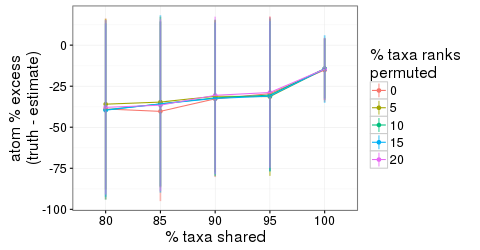

In [275]:
%%R -h 250 
# difference between true and estimated
df.j.dis.dBD = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(shared_perc, perm_perc, true_incorporator) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric)) %>%
    filter(true_incorporator == TRUE)
   
# plotting
ggplot(df.j.dis.dBD, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_point() +
    geom_linerange(alpha=0.5, size=0.8) +
    geom_line() +
    scale_color_discrete('% taxa ranks\npermuted') +
    labs(x='% taxa shared', y='atom % excess\n(truth - estimate)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## combined plot

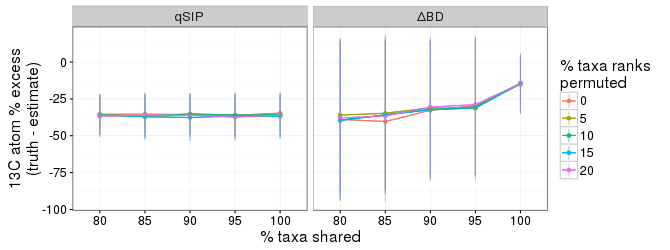

In [276]:
%%R -w 670 -h 250
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='ΔBD'))

# plotting
p.comb = ggplot(df.jj, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_point() +
    geom_linerange(alpha=0.5, size=0.5) +
    geom_line() +
    geom_line() +
    scale_color_discrete('% taxa ranks\npermuted') +
    labs(x='% taxa shared', y='13C atom % excess\n(truth - estimate)') +
    facet_grid(. ~ method) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.comb

## qSIP+deltaBD

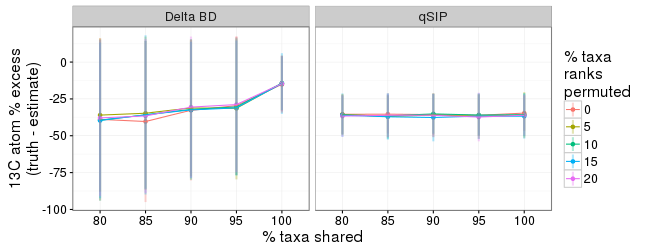

In [288]:
%%R -w 650 -h 250
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='Delta BD'))

# plotting
p.comb = ggplot(df.jj, aes(shared_perc, mean_delta_excess, 
                      color=perm_perc, group=perm_perc,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_point() +
    geom_linerange(alpha=0.3, size=1) +
    geom_line() +
    scale_color_discrete('% taxa\nranks\npermuted') +
    labs(x='% taxa shared', y='13C atom % excess\n(truth - estimate)') +
    facet_grid(. ~ method) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.comb

### Density plots

In [289]:
%%R
df.jj = rbind(df.j.qSIP %>% 
                  dplyr::select(atom_fraction_excess, true_atom_fraction_excess, shared_perc,
                                true_incorporator, perm_perc) %>%
                  mutate(method='qSIP'),
              df.j.dBD %>% 
                  dplyr::select(atom_fraction_excess, true_atom_fraction_excess, shared_perc,
                                true_incorporator, perm_perc) %>%
                  mutate(method='Delta BD')) %>%
    filter(perm_perc == '10',
           true_incorporator==TRUE,
           atom_fraction_excess!=0) %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100,
           shared_perc = shared_perc %>% reorder(shared_perc %>% as.numeric),
           perm_perc = perm_perc %>% reorder(perm_perc %>% as.numeric), 
           atom_perc_excess = atom_fraction_excess * 100,
           true_atom_perc_excess = true_atom_fraction_excess * 100) 

df.jj %>% head(n=3)

  atom_fraction_excess true_atom_fraction_excess shared_perc true_incorporator
1            0.6758098                         1          80              TRUE
2            0.7126439                         1          80              TRUE
3            0.6670081                         1          80              TRUE
  perm_perc method delta_excess atom_perc_excess true_atom_perc_excess
1        10   qSIP    -32.41902         67.58098                   100
2        10   qSIP    -28.73561         71.26439                   100
3        10   qSIP    -33.29919         66.70081                   100


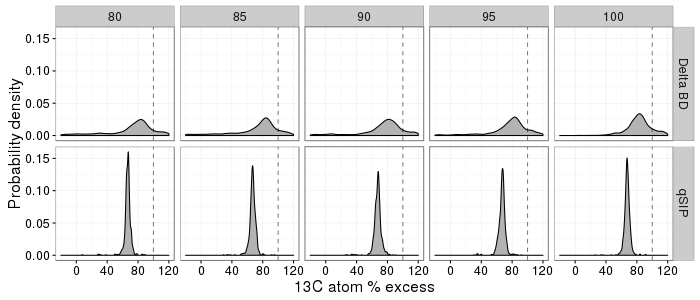

In [290]:
%%R -w 700 -h 300

tmp = df.jj %>%
    dplyr::select(true_atom_perc_excess, shared_perc, method) %>%
    distinct(shared_perc, method) 

p.dens = ggplot(df.jj, aes(atom_perc_excess)) +
    geom_density(fill='grey70') +
    geom_vline(data=tmp, aes(xintercept=true_atom_perc_excess), linetype='dashed', alpha=0.5) +
    scale_x_continuous(limits=c(-20, 120)) +
    labs(x='13C atom % excess', y='Probability density') +
    facet_grid(method ~ shared_perc) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.dens

### Combined plot

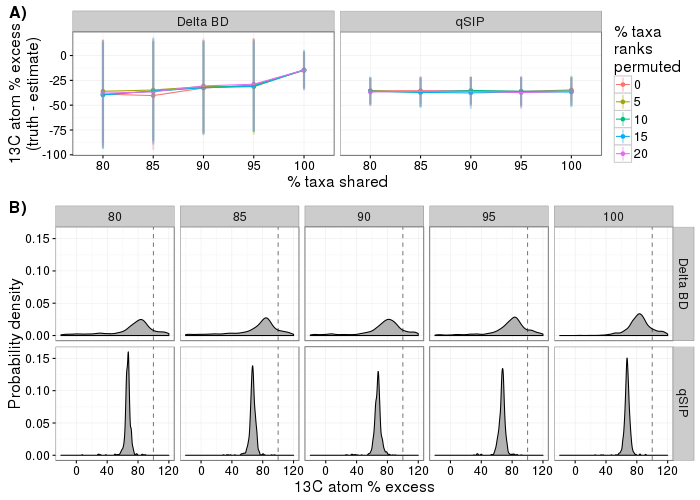

In [291]:
%%R -w 700 -h 500

p.comb2 = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), color='white', fill='white') +
    cowplot::draw_plot(p.comb, 0, 0.61, 1, 0.38) +
    cowplot::draw_plot(p.dens, 0, 0, 1, 0.60) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.61))
p.comb2

In [292]:
%%R
outFile = 'microBetaDiv_qSIP-dBD.pdf'
ggsave(outFile, p.comb2, width=10, height=7.15)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/microBetaDiv/microBetaDiv_qSIP-dBD.pdf 


***
# Sandbox